**<h2>Importing all necessary libraries</h2>**

In [1]:
import os

import cv2
import json
import pickle
import operator
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json


2021-12-16 07:24:12.185003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/prabhat/Desktop/maggie_project/maggie/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64:
2021-12-16 07:24:12.185029: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


**<h2>Loading product details into the pandas dataframe.</h2>**

In [13]:
styles_df =  pd.read_csv('data/product_details.csv')
print(styles_df.shape)
styles_df.head()

(44077, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


**<h2>Loading product embeddings into the pandas dataframe.</h2>**

In [3]:
reduced_df =  pd.read_csv('data/product_embeddings.csv')
print(reduced_df.shape)
reduced_df.head()

(44072, 129)


,image_id,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,2327,0.368859,-11.685857,2.055406,-0.816074,-0.239823,-1.573246,2.448108,-0.186323,-2.668401,...,-1.296527,-0.391367,0.717054,0.270023,-0.144781,-0.357175,-1.681443,1.026930,-0.169140,0.791965
1,7234,-10.835526,15.768022,-0.797385,-7.051925,-2.622900,2.910861,-3.050789,0.067406,2.661086,...,0.757278,0.770042,-0.382813,0.538873,-0.400392,-0.231881,0.158243,-0.674300,-0.812090,-0.571694
2,56318,-6.558609,-13.284967,2.181063,-0.269254,0.058580,1.057284,-1.996780,0.450176,0.483667,...,0.279345,0.362061,-0.736234,-0.058976,-0.131799,-0.210975,0.738301,0.124449,0.144801,0.211637
3,20802,-14.581285,9.247222,-0.296349,-0.908858,-0.225791,-0.004434,-0.248707,0.250197,2.855885,...,0.594506,0.083636,-0.605023,0.523227,0.172472,-0.099407,0.424567,0.049007,0.763460,0.513691
4,44760,-10.953700,3.873663,1.345367,-2.870668,-3.264861,0.479384,0.332739,-0.998868,-0.102779,...,0.622825,0.488579,0.056295,0.373797,-0.585484,0.018307,-0.164701,0.243420,-0.198292,-0.218019


**<h2>Defining image directory and assigning varibles to resemble input image size.</h2>**

In [4]:
image_dir = 'images'
image_shape = (299,299)

**<h2>Loading Model from pretrained weights and configurations files</h2>**

In [5]:
# load json and create model
json_file = open('models/xception_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("models/xception_model.h5")
print("Loaded model from disk")

2021-12-16 07:24:36.227741: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-16 07:24:36.227776: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (prabhat-VivoBook-15-ASUS-Laptop-X542UF): /proc/driver/nvidia/version does not exist
2021-12-16 07:24:36.228370: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded model from disk


**<h2>Loading feature scales of the training data from the pickle file</h2>**

In [6]:
with open('models/scaler.pickle', 'rb') as file:
  scaler = pickle.load(file)


**<h2>Loading pca features of the training data from the pickle file.</h2>**

In [7]:
with open('models/pca.pickle', 'rb') as file:
  pca = pickle.load(file)

In [8]:
def calculate_embeddings(img, input_shape, model):

  img_arr = cv2.imread(img)
  resized_img_arr = cv2.resize(img_arr, input_shape)
  model_input = np.expand_dims(resized_img_arr, axis = 0)
  prediction = model.predict(model_input)
  return prediction


**<li>This function calculates the embeddings for each product image and return 2048 dimensional vectors for each image supplied.</li>**

In [9]:
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

**<li>This function takes in two vectors and calculates the similarity score of two vectors.</li>**

**<li>Greater is the similarity score, the higher similar the two products are and higher the chance of being recommended to each other.</li>**

**<h2>Inference</h2>**

<h2>Taking testing image and extracting 2048 dimension embedding for that testing image</h2>

In [10]:
query_image = 'images/10009.jpg'
query_id = int(query_image.split('/')[-1].split('.')[0])
query_embedding = calculate_embeddings(query_image, image_shape, model)
print(query_embedding)

[[ 0.        8.332608 63.085556 ...  0.       25.859629  0.      ]]


**<h2>Performing Feature Scaling and then applying PCA to the scaled features of query embeddings</h2>**

In [11]:
scaled_query_data = scaler.transform(query_embedding)
reduced_query_data = pca.transform(scaled_query_data)
print(reduced_query_data.shape)

(1, 128)


**<h2>Selecting the articleType and gender related to the product from the imageid</h2>**

In [12]:
reference_categories = styles_df.loc[styles_df['id'] == query_id, ["articleType","gender"]]
reference_article_type = reference_categories["articleType"].values[0]
reference_gender = reference_categories["gender"].values[0]
print(reference_article_type)
print(type(reference_article_type))
print(reference_gender)
print(type(reference_gender))

Tshirts
<class 'str'>
Men
<class 'str'>


**<li>We get an image_id of the product from the input image.</li>**

**<li>Then we find the "articleType" of the product from the given id.</li>**

**<li>After we find the "articleType, we find the gender whom the product are designed for.</li>**

**<h2>Searching product with similar 'articleType' which can be worn by the same 'gender' as the input image.</h2>**

In [14]:
searchable_products = styles_df.loc[styles_df['gender'] == reference_gender]
searchable_product_ids = list(searchable_products.loc[searchable_products['articleType'] == reference_article_type, 'id'])
searchable_product_ids = [prod_id for prod_id in searchable_product_ids if prod_id != query_id]
print(len(searchable_product_ids))
print(type(searchable_product_ids[0]))

5241
<class 'int'>


**<li>We then get x number of products which has similar gender and belongs to the same 'articleType' as the input image.</li>**

**<li>Here, we are using filter to choose only those products which are worn by same gender as the query image and belongs to the same 'articleType' as the query image because recommending female products to the male gender doesnot make sense and recommending pants when someone is looking for shirt also doesn't make sense.</li>**

**<h2>Calculating the similarity score of other similar products with the query product.</h2>**

In [15]:
searchable_df = reduced_df.loc[reduced_df['image_id'].isin(searchable_product_ids)].reset_index(drop=True)
similarity_scores = {}
for item in tqdm(searchable_df.values):
  img_id = int(item[0])
  vector_embedding = item[1:]
  sim_score = cosine_similarity(reduced_query_data, vector_embedding)
  similarity_scores[img_id] = sim_score[0]  

100%|████████████████████████████████████| 5240/5240 [00:00<00:00, 45203.75it/s]


**<h2>Selecting top 5 products which have higher similarity scores among them all</h2>**

In [16]:
print(similarity_scores)
sorted_similarity_scores = dict(sorted(similarity_scores.items(), key = operator.itemgetter(1),reverse=True))
top_five_similarity_scores = list(sorted_similarity_scores.values())[:5]
top_five_similarity_scores_id = list(sorted_similarity_scores.keys())[:5]
print(top_five_similarity_scores)
print(top_five_similarity_scores_id)

{2327: -0.17548409193861036, 13226: -0.1533716534631442, 17252: 0.3025001501926846, 7908: 0.30770132545893464, 3107: 0.34505103197415243, 52059: 0.01624835672154742, 5513: 0.16691576122497018, 44874: 0.29867738322743087, 29247: 0.02129083254494632, 4961: -0.27111968698464445, 7745: 0.29127625828968895, 16503: 0.0360053529161141, 4748: 0.04906120629729767, 3762: 0.2207925396880524, 37713: 0.39624344902656056, 5823: 0.03086307758984375, 3283: 0.3605084020431113, 12652: 0.02453387772136474, 13254: -0.1333661319183487, 16901: 0.22310332883365572, 26492: -0.0360935493730653, 3017: -0.1663261018526041, 4765: 0.3786780104467769, 28525: 0.790729206000753, 5815: -0.12031532758959482, 46382: 0.16424401858759513, 5839: -0.050513855733564136, 5743: -0.15079962757405538, 8392: -0.024106272733957494, 33081: 0.28920265593200517, 15468: 0.1753318894720762, 56753: 0.2586623009170284, 2860: 0.26835961991604657, 34366: 0.3376695984396387, 10005: 0.7939526028756683, 5716: 0.21596940844947732, 13954: -0.18

**<h2>Displaying Top 5 recommended products according to content similarity(image)</h2>**

Original Image
Recommended Image


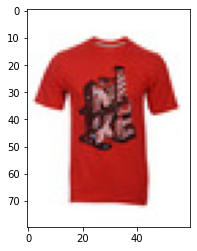

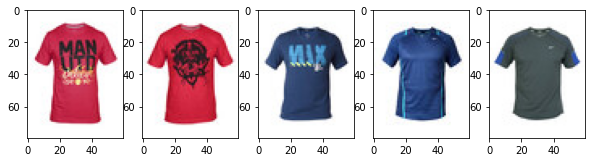

In [17]:
img = plt.imread(os.path.join(image_dir, str(query_id) + '.jpg'))
print("Original Image")
plt.imshow(img)

print("Recommended Image")
fig = plt.figure(figsize=(10,10))
# for imgid in top_five_similarity_scores_id:
rows = 1
cols = 5
for i in range(1,rows * cols + 1):
    fig.add_subplot(rows,cols,i)
    img_array = plt.imread(os.path.join(image_dir, str(top_five_similarity_scores_id[i-1]) + '.jpg'))
    fig.subplots_adjust(hspace=1)
    plt.imshow(img_array)
plt.show()